In [783]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [784]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [785]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [786]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [787]:
train_delta_t = 0
max_depth = 4
eval_metric = 'rmse'
n_estimators = 10000
scaler_name = 'MinMaxScaler'
scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()
y_scaler_name = 'StandardScaler'
y_scaler_a = StandardScaler()
y_scaler_b = StandardScaler()
y_scaler_c = StandardScaler()
random_state = 42
test_size = .15
submission_path = 'random_set_sub/'

In [788]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

In [789]:
def clean_reshaped_data(df: pd.DataFrame):
    columns_to_drop = ['date_forecast_1', 'date_forecast_2', 'date_forecast_0']
    df_cleaned = df.copy()
    df_cleaned.rename(columns={'date_forecast_3': 'date_forecast'}, inplace=True)
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)
    df_cleaned['date_forecast'] = df_cleaned['date_forecast'] # + pd.Timedelta(hours=1)
    return df_cleaned

X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.get_reshaped_files3()

X_train_estimated_a = clean_reshaped_data(X_train_estimated_a)
X_train_estimated_b = clean_reshaped_data(X_train_estimated_b)
X_train_estimated_c = clean_reshaped_data(X_train_estimated_c)
X_train_observed_a = clean_reshaped_data(X_train_observed_a)
X_train_observed_b = clean_reshaped_data(X_train_observed_b)
X_train_observed_c = clean_reshaped_data(X_train_observed_c)
X_test_estimated_a = clean_reshaped_data(X_test_estimated_a)
X_test_estimated_b = clean_reshaped_data(X_test_estimated_b)
X_test_estimated_c = clean_reshaped_data(X_test_estimated_c)

# B and C clean up

In [790]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [791]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [792]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [793]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [794]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [795]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [796]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [797]:
def gestion_nan(df):
  df_copy = df.copy()
  snow_density = [ f'snow_density:kgm3_{k}' for k in range(4) ]
  #delete of the snow density column
  for k in range(4): 
    df_copy = df_copy.drop(snow_density[k],axis=1)
  # Approximation of the other two columns
    df_copy[f'ceiling_height_agl:m_{k}'] = df_copy[f'ceiling_height_agl:m_{k}'].interpolate(method='linear', limit_direction='both')
    df_copy[f'cloud_base_agl:m_{k}'] = df_copy[f'cloud_base_agl:m_{k}'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [798]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [799]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

30904
4577
0.12899861897917195


In [800]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [801]:
# split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
# split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
# split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [802]:
# split_date_a = pd.to_datetime("2021-04-15")
# split_date2_a = pd.to_datetime("2021-08-15")

# split_date_b = pd.to_datetime("2019-04-15")
# split_date2_b = pd.to_datetime("2019-08-15")

# split_date_c = pd.to_datetime("2021-04-15")
# split_date2_c = pd.to_datetime("2021-08-15")

In [803]:
start_2019 = pd.to_datetime("2019-04-21")
end_2019 = pd.to_datetime("2019-07-22")

start_2020 = pd.to_datetime("2020-04-21")
end_2020 = pd.to_datetime("2020-07-22")

start_2021 = pd.to_datetime("2021-04-21")
end_2021 = pd.to_datetime("2021-07-22")

start_2022 = pd.to_datetime("2022-04-21")
end_2022 = pd.to_datetime("2022-07-22")

In [804]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated

In [805]:
def split_training_testing_set(df, start_estimated, random_state=42, test_size = .1, time_column = 'date_forecast'):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]

    test_size = test_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    # train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    unique_dates = df_summers[time_column].dt.date.unique()

    train_dates, test_dates = train_test_split(unique_dates, test_size=test_size, random_state=random_state)

    train_data_summer = df_summers[df_summers[time_column].dt.date.isin(train_dates)]
    pv_test_not_ordered = df_summers[df_summers[time_column].dt.date.isin(test_dates)]

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by=time_column)
    pv_test = pv_test_not_ordered.sort_values(by=time_column)
    return pv_train, pv_test, test_dates

In [806]:
pv_train_a, pv_test_a, test_dates_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), test_size=test_size, random_state=random_state)
pv_train_b, pv_test_b, test_dates_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), test_size=test_size, random_state=random_state)
pv_train_c, pv_test_c, test_dates_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), test_size=test_size, random_state=random_state)

In [807]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (28931, 178)
test_a : (5113, 178)
Rapport test/total : 15.0
train_b : (20021, 178)
test_b : (3540, 178)
Rapport test/total : 15.0
train_c : (18430, 178)
test_c : (3271, 178)
Rapport test/total : 15.1


## Changement type de la date_forecast

In [808]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [809]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(columns="date_forecast",axis=1) # date de calcul des estimated inutil pour l'instant
    
    for k in range(4):
        df[f'sun_azimuth:d_{k}'] = df[f'sun_azimuth:d_{k}'].apply(lambda x : np.cos(x/180*np.pi + np.pi))

    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [810]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [811]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None,fit=True):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : 
      if fit:
        normalized_data = scaler.fit_transform(df)
      else: 
        normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [812]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [813]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a, fit=False)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b, fit=False)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c, fit=False)

In [814]:
y_train_a, y_scaler_a = sklearn_z_score_normalize_dataframe(pd.DataFrame(y_train_a),return_scaler=True,scaler=y_scaler_a)
y_train_b, y_scaler_b = sklearn_z_score_normalize_dataframe(pd.DataFrame(y_train_b),return_scaler=True,scaler=y_scaler_b)
y_train_c, y_scaler_c = sklearn_z_score_normalize_dataframe(pd.DataFrame(y_train_c),return_scaler=True,scaler=y_scaler_c)

y_test_a = pd.DataFrame(y_scaler_a.transform(pd.DataFrame(y_test_a)))
y_test_b = pd.DataFrame(y_scaler_b.transform(pd.DataFrame(y_test_b)))
y_test_c = pd.DataFrame(y_scaler_c.transform(pd.DataFrame(y_test_c)))

In [815]:
locations = ['A', 'B', 'C']
def concat_df_from_differents_locations(dfs):
    dfs_to_concat = { k: df.copy() for (k, df) in dfs.items() }
    for key, df in dfs_to_concat.items():
        for loc in locations:
            df[f'location_{loc}'] = 0
        df[f'location_{key}'] = 1
    dfs_to_concat_listed = [ df for _, df in dfs_to_concat.items() ]
    df_to_return = pd.concat(dfs_to_concat_listed, ignore_index=True)
    return df_to_return

In [816]:
X_train_to_concat = { 'A': X_train_a_norm, 'B': X_train_b_norm, 'C': X_train_c_norm }
X_train_norm = concat_df_from_differents_locations(X_train_to_concat)

X_test_to_concat = { 'A': X_test_a_norm, 'B': X_test_b_norm, 'C': X_test_c_norm }
X_test_norm = concat_df_from_differents_locations(X_test_to_concat)

y_train = pd.concat([y_train_a, y_train_b, y_train_c], ignore_index=True)
y_test= pd.concat([y_test_a, y_test_b, y_test_c], ignore_index=True)

In [817]:
# from sklearn.inspection import permutation_importance
# from sklearn.linear_model import Ridge

# model = Ridge(alpha=1e-2).fit(X_train_norm, y_train)
# r = permutation_importance(model, X_test_norm, y_test,
#        n_repeats=30,
#        random_state=0)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{X_train_norm.columns[i]:<8} {r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

In [818]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{X_train_norm.columns[i]:<8}        {r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [819]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [820]:
# y_test = np.array(y_test)

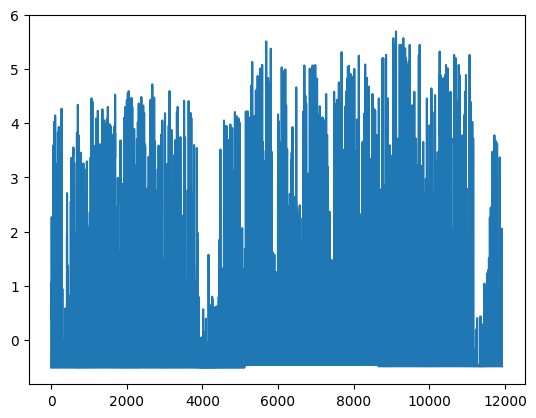

In [821]:
plt.plot(y_test)

In [822]:
reg = xgb.XGBRegressor(n_estimators =  n_estimators,
                    max_depth = max_depth,
                    eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg.fit(X_train_norm, y_train,
          eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:0.76576	validation_1-rmse:1.19209
[1]	validation_0-rmse:0.61395	validation_1-rmse:0.95191
[2]	validation_0-rmse:0.51735	validation_1-rmse:0.80238
[3]	validation_0-rmse:0.45958	validation_1-rmse:0.71890
[4]	validation_0-rmse:0.42521	validation_1-rmse:0.67017
[5]	validation_0-rmse:0.40292	validation_1-rmse:0.63808
[6]	validation_0-rmse:0.39054	validation_1-rmse:0.62191
[7]	validation_0-rmse:0.38182	validation_1-rmse:0.61224
[8]	validation_0-rmse:0.37398	validation_1-rmse:0.60212
[9]	validation_0-rmse:0.36877	validation_1-rmse:0.59713
[10]	validation_0-rmse:0.36440	validation_1-rmse:0.59182
[11]	validation_0-rmse:0.36158	validation_1-rmse:0.59103
[12]	validation_0-rmse:0.35950	validation_1-rmse:0.58917


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:0.35665	validation_1-rmse:0.58599
[14]	validation_0-rmse:0.35425	validation_1-rmse:0.58530
[15]	validation_0-rmse:0.35227	validation_1-rmse:0.58418
[16]	validation_0-rmse:0.35050	validation_1-rmse:0.58356
[17]	validation_0-rmse:0.34899	validation_1-rmse:0.58242
[18]	validation_0-rmse:0.34747	validation_1-rmse:0.58281
[19]	validation_0-rmse:0.34657	validation_1-rmse:0.58248
[20]	validation_0-rmse:0.34476	validation_1-rmse:0.58123
[21]	validation_0-rmse:0.34320	validation_1-rmse:0.58042
[22]	validation_0-rmse:0.34172	validation_1-rmse:0.58002
[23]	validation_0-rmse:0.34068	validation_1-rmse:0.57930
[24]	validation_0-rmse:0.33920	validation_1-rmse:0.57856
[25]	validation_0-rmse:0.33745	validation_1-rmse:0.57863
[26]	validation_0-rmse:0.33625	validation_1-rmse:0.57826
[27]	validation_0-rmse:0.33440	validation_1-rmse:0.57741
[28]	validation_0-rmse:0.33314	validation_1-rmse:0.57716
[29]	validation_0-rmse:0.33252	validation_1-rmse:0.57688
[30]	validation_0-rmse:0.33160	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [823]:
reg = xgb.XGBRegressor(n_estimators =  n_estimators,
                    max_depth = max_depth,
                    eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg.fit(X_train_norm, y_train,
          eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],
          early_stopping_rounds=50,
          verbose=True)


[0]	validation_0-rmse:0.76576	validation_1-rmse:1.19209
[1]	validation_0-rmse:0.61395	validation_1-rmse:0.95191
[2]	validation_0-rmse:0.51735	validation_1-rmse:0.80238
[3]	validation_0-rmse:0.45958	validation_1-rmse:0.71890
[4]	validation_0-rmse:0.42521	validation_1-rmse:0.67017
[5]	validation_0-rmse:0.40292	validation_1-rmse:0.63808
[6]	validation_0-rmse:0.39054	validation_1-rmse:0.62191
[7]	validation_0-rmse:0.38182	validation_1-rmse:0.61224
[8]	validation_0-rmse:0.37398	validation_1-rmse:0.60212
[9]	validation_0-rmse:0.36877	validation_1-rmse:0.59713
[10]	validation_0-rmse:0.36440	validation_1-rmse:0.59182
[11]	validation_0-rmse:0.36158	validation_1-rmse:0.59103


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:0.35950	validation_1-rmse:0.58917
[13]	validation_0-rmse:0.35665	validation_1-rmse:0.58599
[14]	validation_0-rmse:0.35425	validation_1-rmse:0.58530
[15]	validation_0-rmse:0.35227	validation_1-rmse:0.58418
[16]	validation_0-rmse:0.35050	validation_1-rmse:0.58356
[17]	validation_0-rmse:0.34899	validation_1-rmse:0.58242
[18]	validation_0-rmse:0.34747	validation_1-rmse:0.58281
[19]	validation_0-rmse:0.34657	validation_1-rmse:0.58248
[20]	validation_0-rmse:0.34476	validation_1-rmse:0.58123
[21]	validation_0-rmse:0.34320	validation_1-rmse:0.58042
[22]	validation_0-rmse:0.34172	validation_1-rmse:0.58002
[23]	validation_0-rmse:0.34068	validation_1-rmse:0.57930
[24]	validation_0-rmse:0.33920	validation_1-rmse:0.57856
[25]	validation_0-rmse:0.33745	validation_1-rmse:0.57863
[26]	validation_0-rmse:0.33625	validation_1-rmse:0.57826
[27]	validation_0-rmse:0.33440	validation_1-rmse:0.57741
[28]	validation_0-rmse:0.33314	validation_1-rmse:0.57716
[29]	validation_0-rmse:0.33252	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [824]:
# dtrain = xgb.DMatrix(data=X_train_norm, label=y_train)
# dtest= xgb.DMatrix(data=X_test_norm, label=y_test)
# num_parallel_tree = 4
# num_boost_round = 16

# booster = xgb.train({
#     'num_parallel_tree': num_parallel_tree, 'subsample': 0.5, 'num_class': 3},
#                     num_boost_round=num_boost_round, dtrain=dtrain)


# bst = xgb.train(dtrain)
# ypred = bst.predict(dtest)

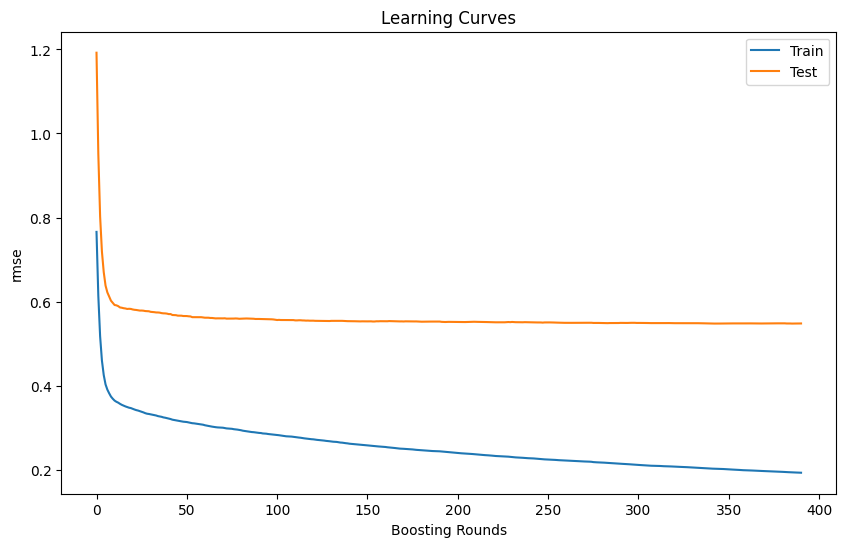

In [825]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)

In [826]:
min_error_a

0.5475956428424448

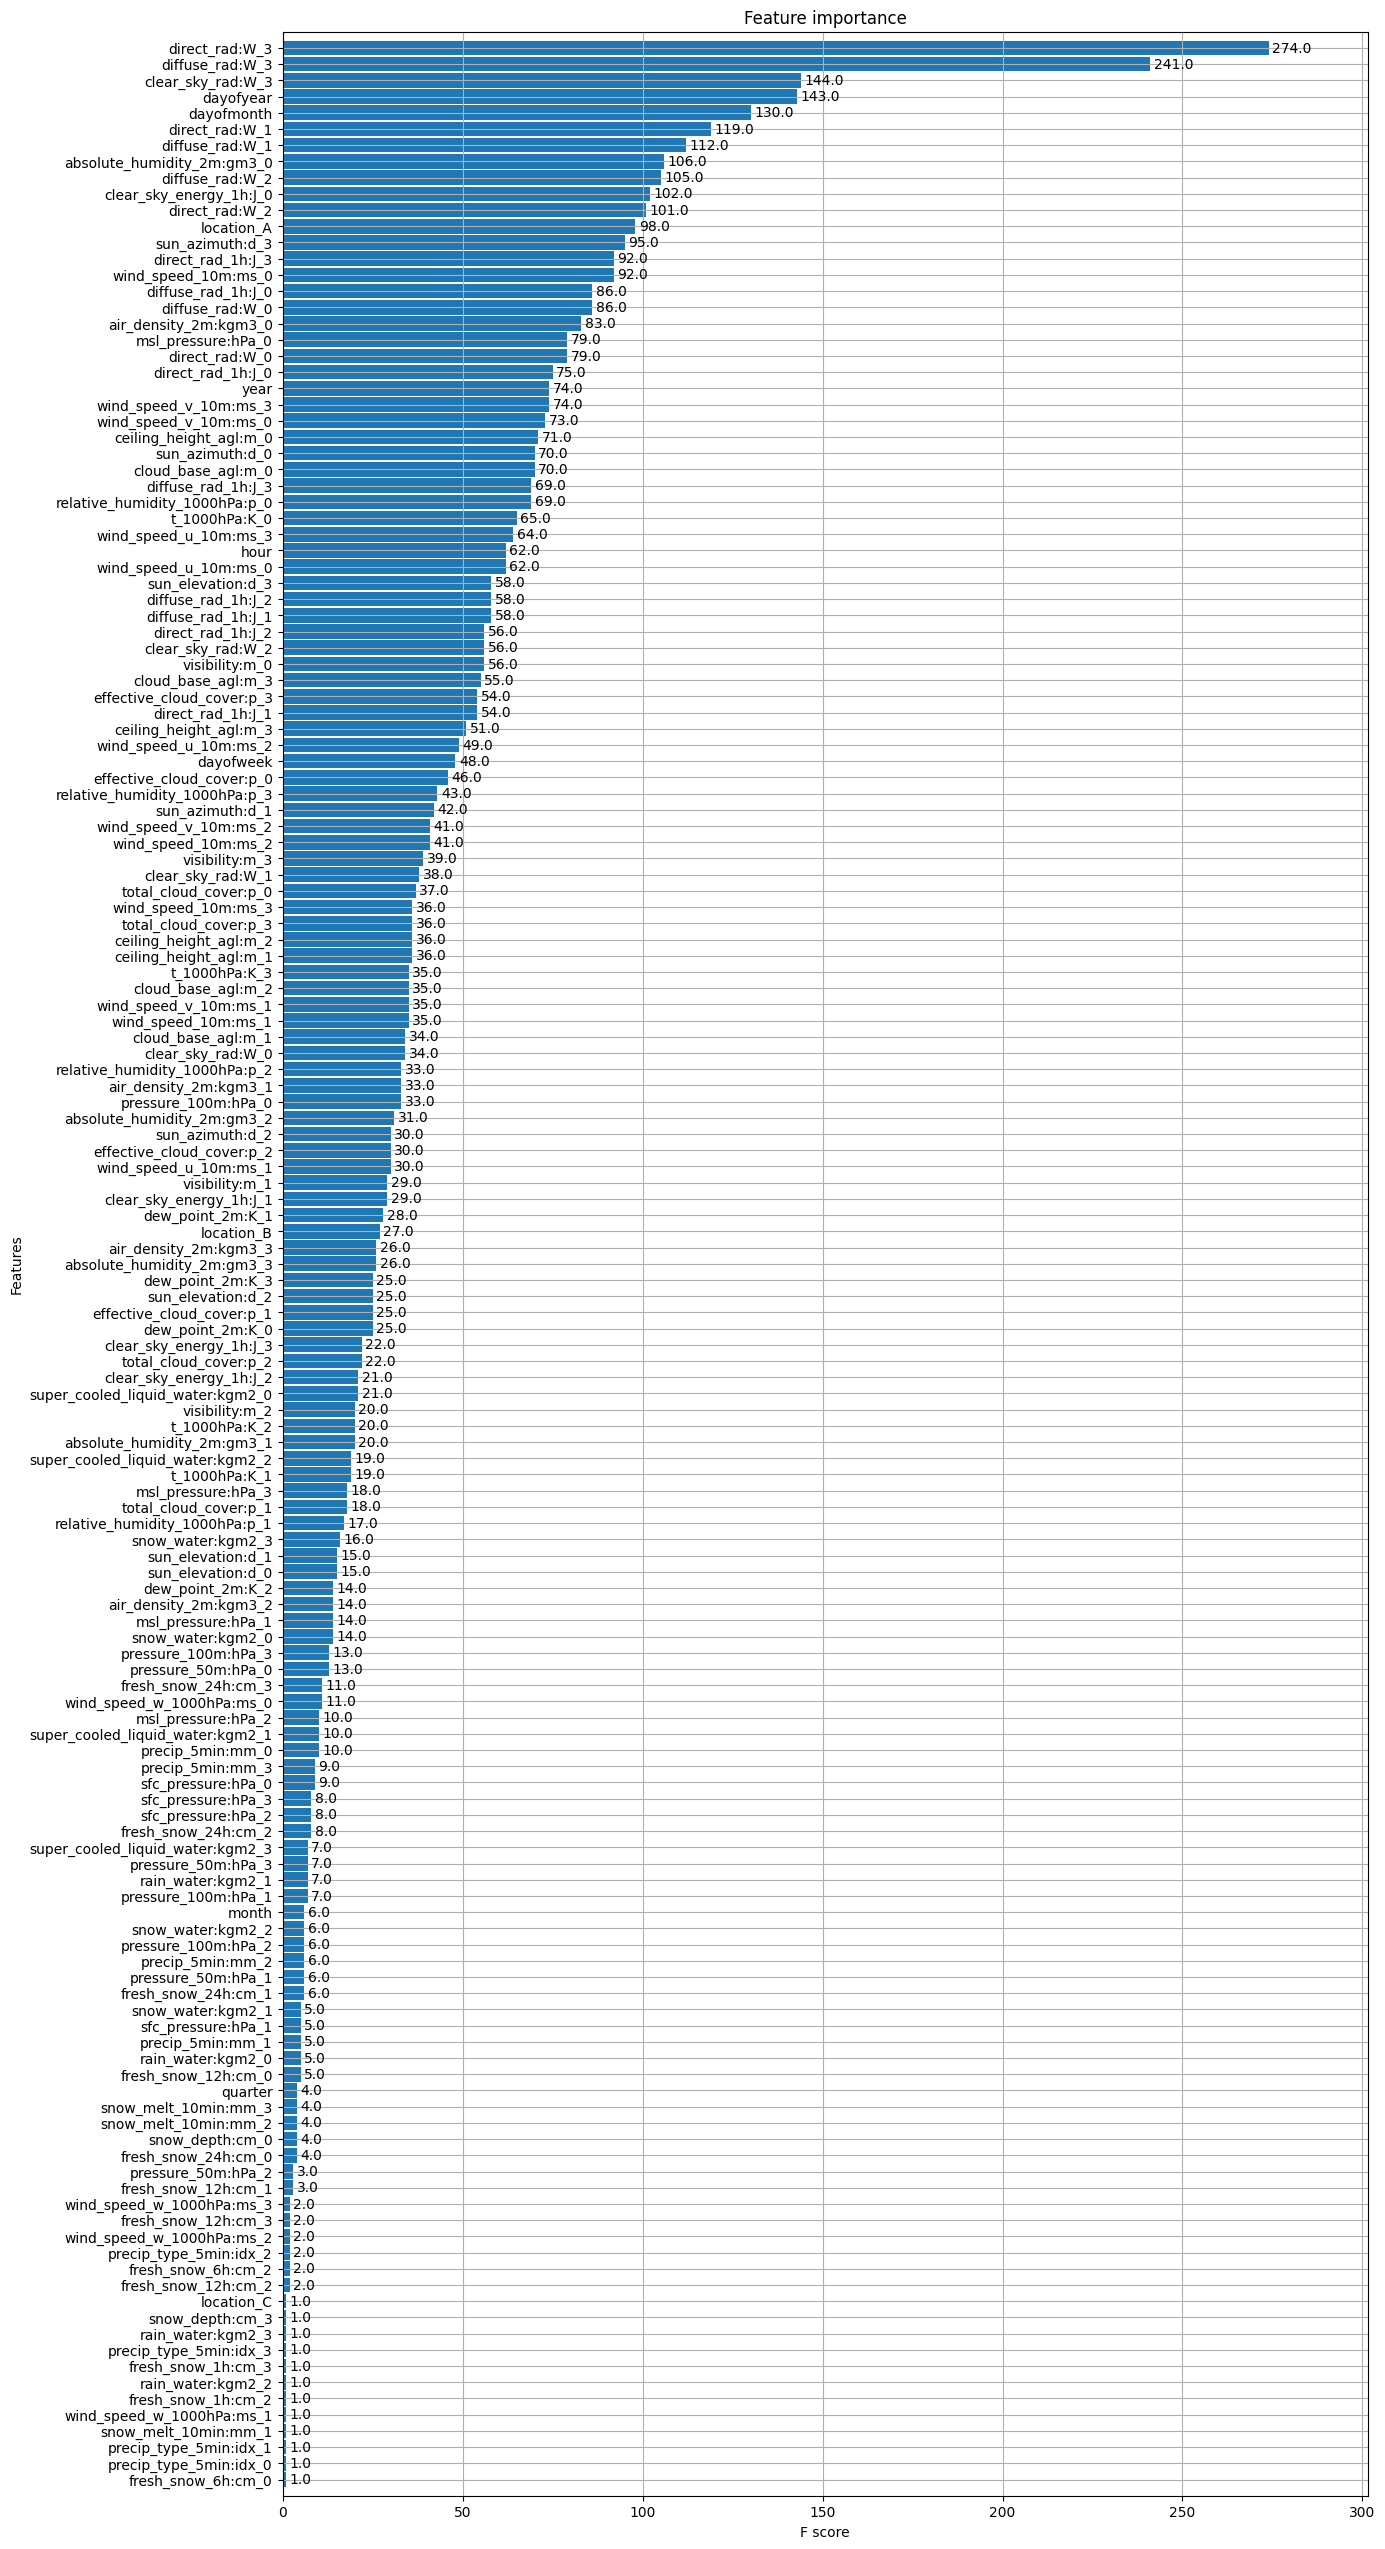

In [827]:
plot_importance(reg, height=.9)
plt.gcf().set_size_inches(14, 8 * 4)

In [828]:
pv_test_to_concate= { 
    'A': pv_test_a, 
    'B': pv_test_b, 
    'C': pv_test_c 
    }
pv_test = concat_df_from_differents_locations(pv_test_to_concate)

pv_train_to_concate = { 
    'A': pv_train_a, 
    'B': pv_train_b, 
    'C': pv_train_c
    }
# { 'A': pv_train_a, 'B': pv_train_b, 'C': pv_train_c }
pv_train = concat_df_from_differents_locations(pv_train_to_concate)

In [829]:
pred_a = y_scaler_a.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg.predict(X_test_norm[X_test_norm['location_A'] == 1])})).reshape(-1)
pred_b = y_scaler_b.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg.predict(X_test_norm[X_test_norm['location_B'] == 1])})).reshape(-1)
pred_c = y_scaler_c.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg.predict(X_test_norm[X_test_norm['location_C'] == 1])})).reshape(-1)

In [830]:
pv_test['pv_measurement_prediction'] = pd.NA
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_a)) & pv_test['location_A']==1] = pred_a
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_b)) & pv_test['location_B']==1] = pred_b
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_c)) & pv_test['location_C']==1] = pred_c

pv_all = pd.concat([pv_test, pv_train], sort=False)
pv_all = pv_all.sort_values(by=['location_C','location_B','location_A', 'date_forecast'], ignore_index=True)

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/1435070880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_a)) & pv_test['location_A']==1] = pred_a
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/1435070880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_b)) & pv_test['location_B']==1] = pred_b
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/1435070880.py:4: SettingWithCopyWarning: 
A value

In [831]:
mae = np.mean(np.abs(pv_all['pv_measurement'] - pv_all['pv_measurement_prediction']))
print("MAE on test set:", mae)

MAE on test set: 165.800125966425


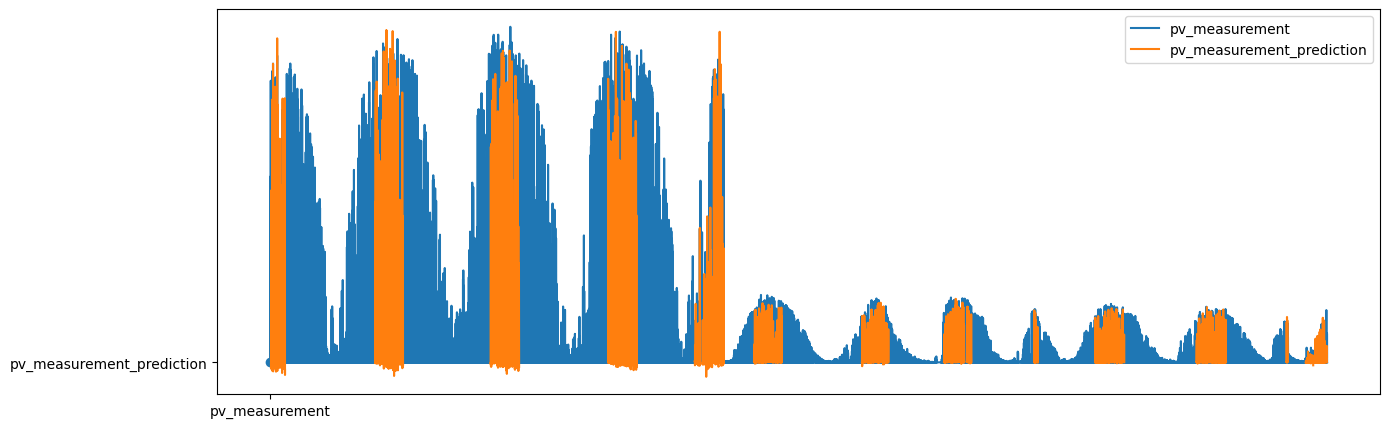

In [832]:
graph = pv_all[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
# graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
# graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

# Clean data

[0]	validation_0-rmse:0.76576	validation_1-rmse:1.19209
[1]	validation_0-rmse:0.61395	validation_1-rmse:0.95191
[2]	validation_0-rmse:0.51735	validation_1-rmse:0.80238
[3]	validation_0-rmse:0.45958	validation_1-rmse:0.71890
[4]	validation_0-rmse:0.42521	validation_1-rmse:0.67017
[5]	validation_0-rmse:0.40292	validation_1-rmse:0.63808
[6]	validation_0-rmse:0.39054	validation_1-rmse:0.62191
[7]	validation_0-rmse:0.38182	validation_1-rmse:0.61224
[8]	validation_0-rmse:0.37398	validation_1-rmse:0.60212
[9]	validation_0-rmse:0.36877	validation_1-rmse:0.59713
[10]	validation_0-rmse:0.36440	validation_1-rmse:0.59182
[11]	validation_0-rmse:0.36158	validation_1-rmse:0.59103
[12]	validation_0-rmse:0.35950	validation_1-rmse:0.58917


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:0.35665	validation_1-rmse:0.58599
[14]	validation_0-rmse:0.35425	validation_1-rmse:0.58530
[15]	validation_0-rmse:0.35227	validation_1-rmse:0.58418
[16]	validation_0-rmse:0.35050	validation_1-rmse:0.58356
[17]	validation_0-rmse:0.34899	validation_1-rmse:0.58242
[18]	validation_0-rmse:0.34747	validation_1-rmse:0.58281
[19]	validation_0-rmse:0.34657	validation_1-rmse:0.58248
[20]	validation_0-rmse:0.34476	validation_1-rmse:0.58123
[21]	validation_0-rmse:0.34320	validation_1-rmse:0.58042
[22]	validation_0-rmse:0.34172	validation_1-rmse:0.58002
[23]	validation_0-rmse:0.34068	validation_1-rmse:0.57930
[24]	validation_0-rmse:0.33920	validation_1-rmse:0.57856
[25]	validation_0-rmse:0.33745	validation_1-rmse:0.57863
[26]	validation_0-rmse:0.33625	validation_1-rmse:0.57826
[27]	validation_0-rmse:0.33440	validation_1-rmse:0.57741
[28]	validation_0-rmse:0.33314	validation_1-rmse:0.57716
[29]	validation_0-rmse:0.33252	validation_1-rmse:0.57688
[30]	validation_0-rmse:0.33160	

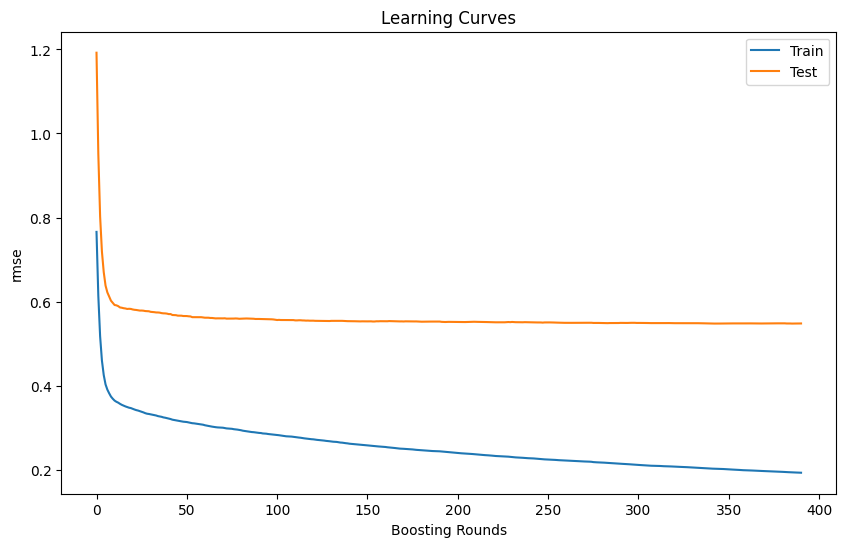

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/3271659382.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_a)) & pv_test['location_A']==1] = pred_a
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/3271659382.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_b)) & pv_test['location_B']==1] = pred_b
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/3271659382.py:71: SettingWithCopyWarning: 
A va

MAE on test set: 165.800125966425


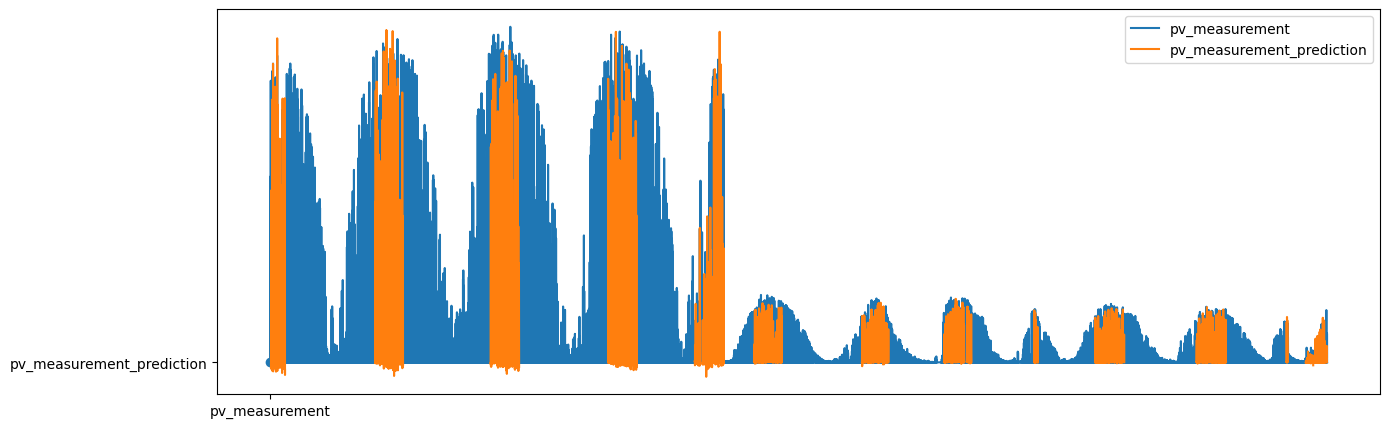

In [833]:
reg.get_booster().get_score(importance_type='weight')

scores = [ (k, v) for k, v in reg.get_booster().get_score(importance_type='weight').items()]

def sort_by_gain(score):
    _, value = score
    return value
scores.sort(key=sort_by_gain)

scored_columns = [ score[0] for score in scores ]
columns_to_drop = [ c for c in X_train_norm.columns if c not in scored_columns]
# columns_to_drop = [ score[0] for score in scores[:len(scores)]]

X_train_norm_columns_droped = X_train_norm.drop(columns=columns_to_drop, inplace=False)
X_test_norm_columns_droped = X_test_norm.drop(columns=columns_to_drop, inplace=False)

reg_2 = xgb.XGBRegressor(n_estimators =  n_estimators,
                    max_depth = max_depth,
                    eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_2.fit(X_train_norm_columns_droped, y_train,
          eval_set=[(X_train_norm_columns_droped, y_train), (X_test_norm_columns_droped, y_test)],
          early_stopping_rounds=50,
          verbose=True)

# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_2.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)

pv_test_to_concate= { 
    'A': pv_test_a, 
    'B': pv_test_b, 
    'C': pv_test_c 
    }
pv_test = concat_df_from_differents_locations(pv_test_to_concate)

pv_train_to_concate = { 
    'A': pv_train_a, 
    'B': pv_train_b, 
    'C': pv_train_c
    }
# { 'A': pv_train_a, 'B': pv_train_b, 'C': pv_train_c }
pv_train = concat_df_from_differents_locations(pv_train_to_concate)

pred_a = y_scaler_a.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg_2.predict(X_test_norm_columns_droped[X_test_norm['location_A'] == 1])})).reshape(-1)
pred_b = y_scaler_b.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg_2.predict(X_test_norm_columns_droped[X_test_norm['location_B'] == 1])})).reshape(-1)
pred_c = y_scaler_c.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg_2.predict(X_test_norm_columns_droped[X_test_norm['location_C'] == 1])})).reshape(-1)

pv_test['pv_measurement_prediction'] = pd.NA
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_a)) & pv_test['location_A']==1] = pred_a
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_b)) & pv_test['location_B']==1] = pred_b
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_c)) & pv_test['location_C']==1] = pred_c

pv_all = pd.concat([pv_test, pv_train], sort=False)
pv_all = pv_all.sort_values(by=['location_C','location_B','location_A', 'date_forecast'], ignore_index=True)

mae = np.mean(np.abs(pv_all['pv_measurement'] - pv_all['pv_measurement_prediction']))
print("MAE on test set:", mae)

graph = pv_all[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')


In [854]:
len(reg_2.get_booster().get_score(importance_type='weight'))

151

In [855]:
len(X_train_norm.columns), len(scores), len(columns_to_drop), len(X_train_norm_columns_droped.columns)

(186, 151, 35, 151)

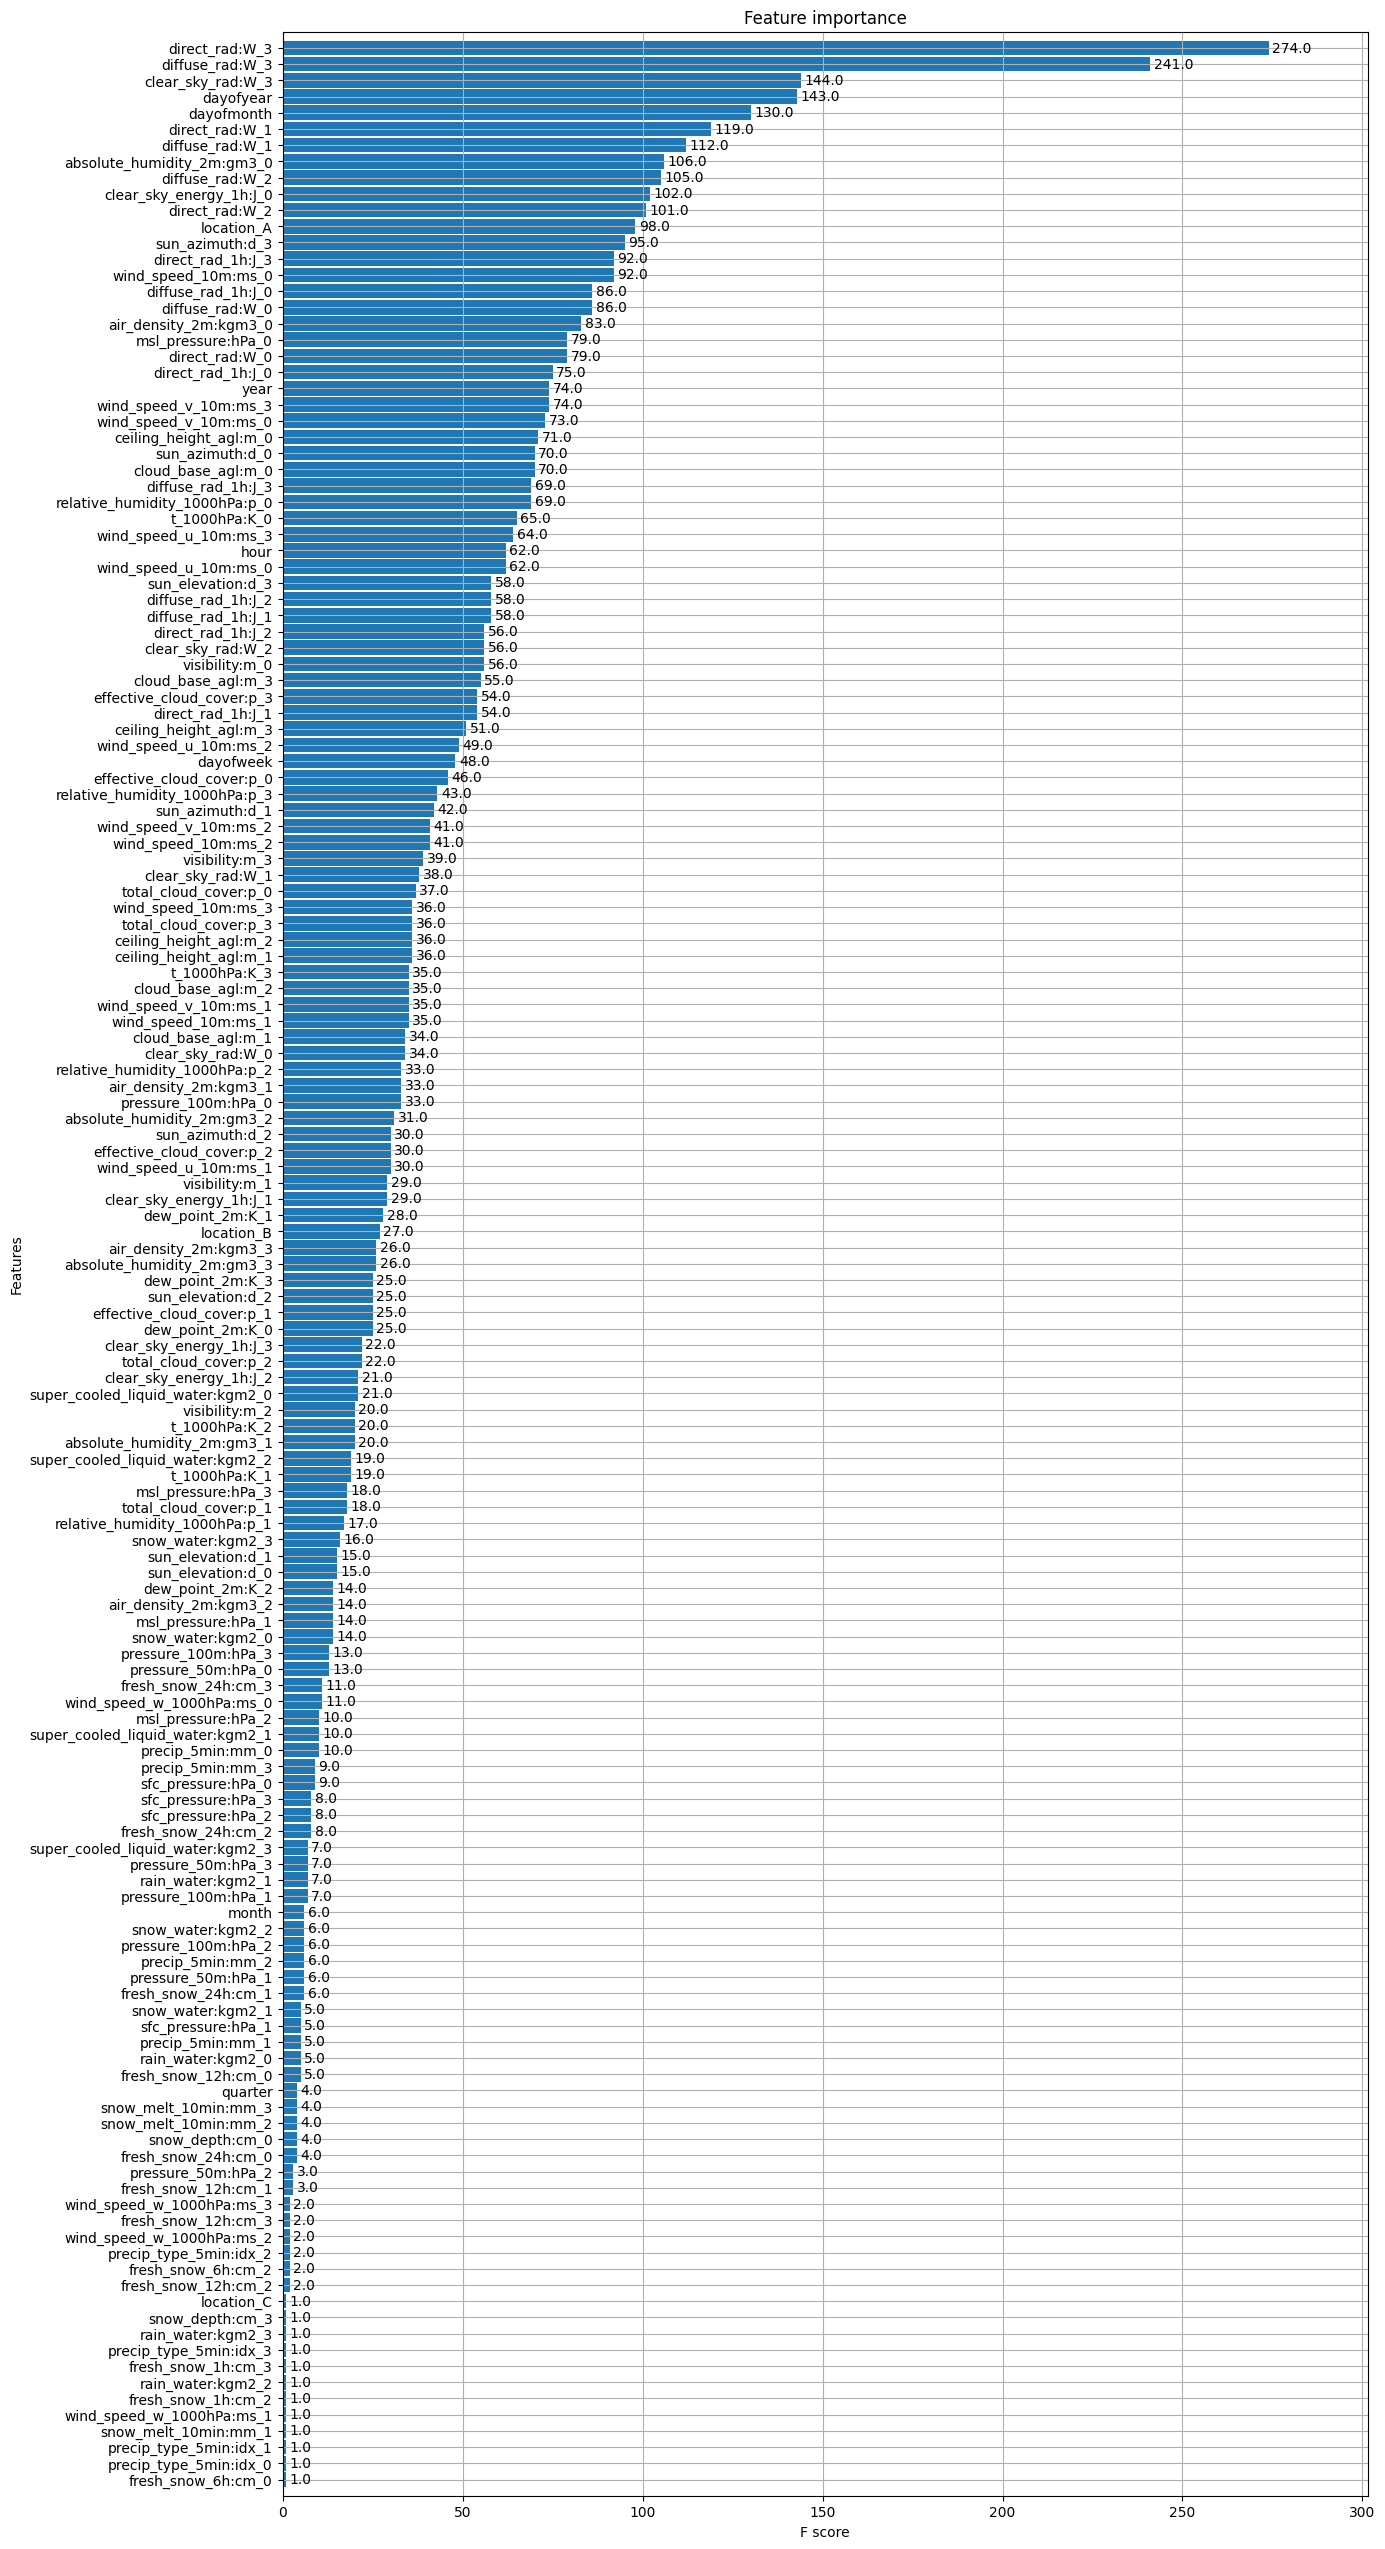

In [836]:
plot_importance(reg_2, height=.9)
plt.gcf().set_size_inches(14, 8 * 4)

[0]	validation_0-rmse:0.76576	validation_1-rmse:1.19200
[1]	validation_0-rmse:0.61401	validation_1-rmse:0.95091
[2]	validation_0-rmse:0.51790	validation_1-rmse:0.80487
[3]	validation_0-rmse:0.46088	validation_1-rmse:0.71492
[4]	validation_0-rmse:0.42711	validation_1-rmse:0.66947
[5]	validation_0-rmse:0.40616	validation_1-rmse:0.64129
[6]	validation_0-rmse:0.39281	validation_1-rmse:0.62364
[7]	validation_0-rmse:0.38217	validation_1-rmse:0.61470
[8]	validation_0-rmse:0.37540	validation_1-rmse:0.60713
[9]	validation_0-rmse:0.37053	validation_1-rmse:0.60083
[10]	validation_0-rmse:0.36771	validation_1-rmse:0.59746
[11]	validation_0-rmse:0.36425	validation_1-rmse:0.59567
[12]	validation_0-rmse:0.36154	validation_1-rmse:0.59357
[13]	validation_0-rmse:0.36027	validation_1-rmse:0.59222
[14]	validation_0-rmse:0.35796	validation_1-rmse:0.59118
[15]	validation_0-rmse:0.35635	validation_1-rmse:0.59006
[16]	validation_0-rmse:0.35397	validation_1-rmse:0.59080
[17]	validation_0-rmse:0.35272	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-rmse:0.34131	validation_1-rmse:0.58494
[26]	validation_0-rmse:0.34047	validation_1-rmse:0.58482
[27]	validation_0-rmse:0.33944	validation_1-rmse:0.58524
[28]	validation_0-rmse:0.33780	validation_1-rmse:0.58446
[29]	validation_0-rmse:0.33683	validation_1-rmse:0.58360
[30]	validation_0-rmse:0.33540	validation_1-rmse:0.58348
[31]	validation_0-rmse:0.33388	validation_1-rmse:0.58247
[32]	validation_0-rmse:0.33274	validation_1-rmse:0.58107
[33]	validation_0-rmse:0.33208	validation_1-rmse:0.58086
[34]	validation_0-rmse:0.33086	validation_1-rmse:0.58140
[35]	validation_0-rmse:0.32908	validation_1-rmse:0.57947
[36]	validation_0-rmse:0.32860	validation_1-rmse:0.57966
[37]	validation_0-rmse:0.32763	validation_1-rmse:0.57949
[38]	validation_0-rmse:0.32682	validation_1-rmse:0.57965
[39]	validation_0-rmse:0.32638	validation_1-rmse:0.57986
[40]	validation_0-rmse:0.32573	validation_1-rmse:0.57927
[41]	validation_0-rmse:0.32521	validation_1-rmse:0.57979
[42]	validation_0-rmse:0.32423	

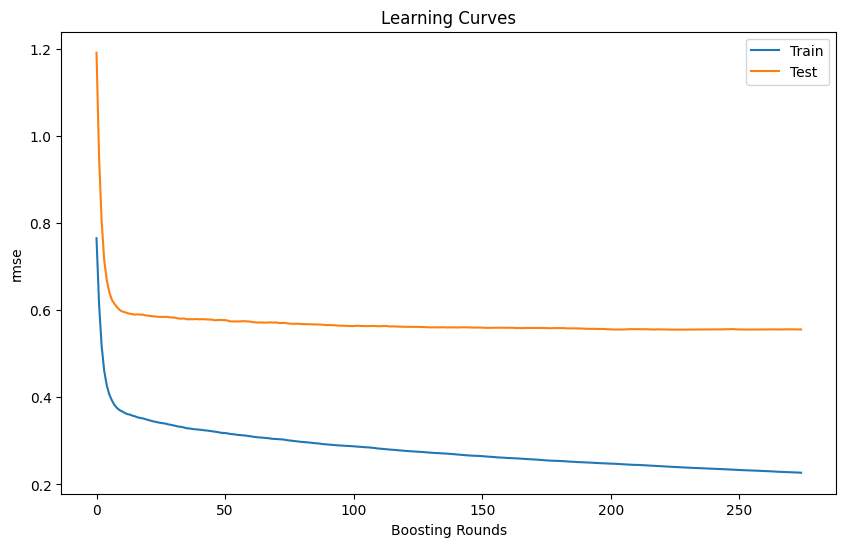

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/1515690631.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_a)) & pv_test['location_A']==1] = pred_a
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/1515690631.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_b)) & pv_test['location_B']==1] = pred_b
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_80620/1515690631.py:71: SettingWithCopyWarning: 
A va

MAE on test set: 169.57042771937427


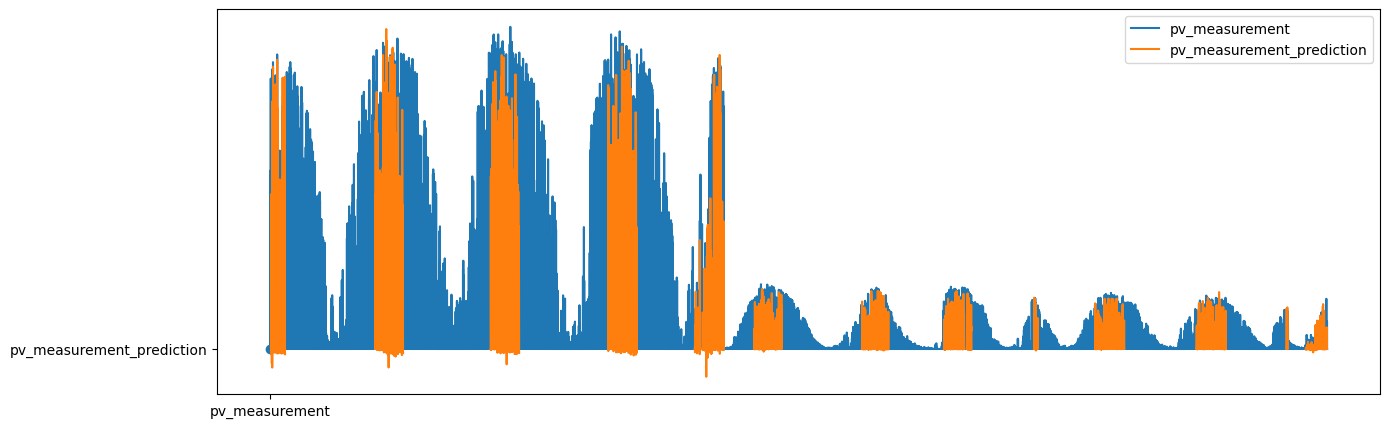

In [858]:
reg_2.get_booster().get_score(importance_type='weight')

scores = [ (k, v) for k, v in reg_2.get_booster().get_score(importance_type='weight').items()]

def sort_by_gain(score):
    _, value = score
    return value
scores.sort(key=sort_by_gain)

# scored_columns = [ score[0] for score in scores ]
# columns_to_drop = [ c for c in X_train_norm.columns if c not in scored_columns]
columns_to_drop = [ score[0] for score in scores[:3 * len(scores)//4]]

X_train_norm_columns_droped = X_train_norm.drop(columns=columns_to_drop, inplace=False)
X_test_norm_columns_droped = X_test_norm.drop(columns=columns_to_drop, inplace=False)

reg_3 = xgb.XGBRegressor(n_estimators =  n_estimators,
                    max_depth = max_depth,
                    eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_3.fit(X_train_norm_columns_droped, y_train,
          eval_set=[(X_train_norm_columns_droped, y_train), (X_test_norm_columns_droped, y_test)],
          early_stopping_rounds=50,
          verbose=True)

# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_3.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)

pv_test_to_concate= { 
    'A': pv_test_a, 
    'B': pv_test_b, 
    'C': pv_test_c 
    }
pv_test = concat_df_from_differents_locations(pv_test_to_concate)

pv_train_to_concate = { 
    'A': pv_train_a, 
    'B': pv_train_b, 
    'C': pv_train_c
    }
# { 'A': pv_train_a, 'B': pv_train_b, 'C': pv_train_c }
pv_train = concat_df_from_differents_locations(pv_train_to_concate)

pred_a = y_scaler_a.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg_3.predict(X_test_norm_columns_droped[X_test_norm['location_A'] == 1])})).reshape(-1)
pred_b = y_scaler_b.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg_3.predict(X_test_norm_columns_droped[X_test_norm['location_B'] == 1])})).reshape(-1)
pred_c = y_scaler_c.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg_3.predict(X_test_norm_columns_droped[X_test_norm['location_C'] == 1])})).reshape(-1)

pv_test['pv_measurement_prediction'] = pd.NA
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_a)) & pv_test['location_A']==1] = pred_a
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_b)) & pv_test['location_B']==1] = pred_b
pv_test['pv_measurement_prediction'][(pv_test['date_forecast'].dt.date.isin(test_dates_c)) & pv_test['location_C']==1] = pred_c

pv_all = pd.concat([pv_test, pv_train], sort=False)
pv_all = pv_all.sort_values(by=['location_C','location_B','location_A', 'date_forecast'], ignore_index=True)

mae = np.mean(np.abs(pv_all['pv_measurement'] - pv_all['pv_measurement_prediction']))
print("MAE on test set:", mae)

graph = pv_all[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')


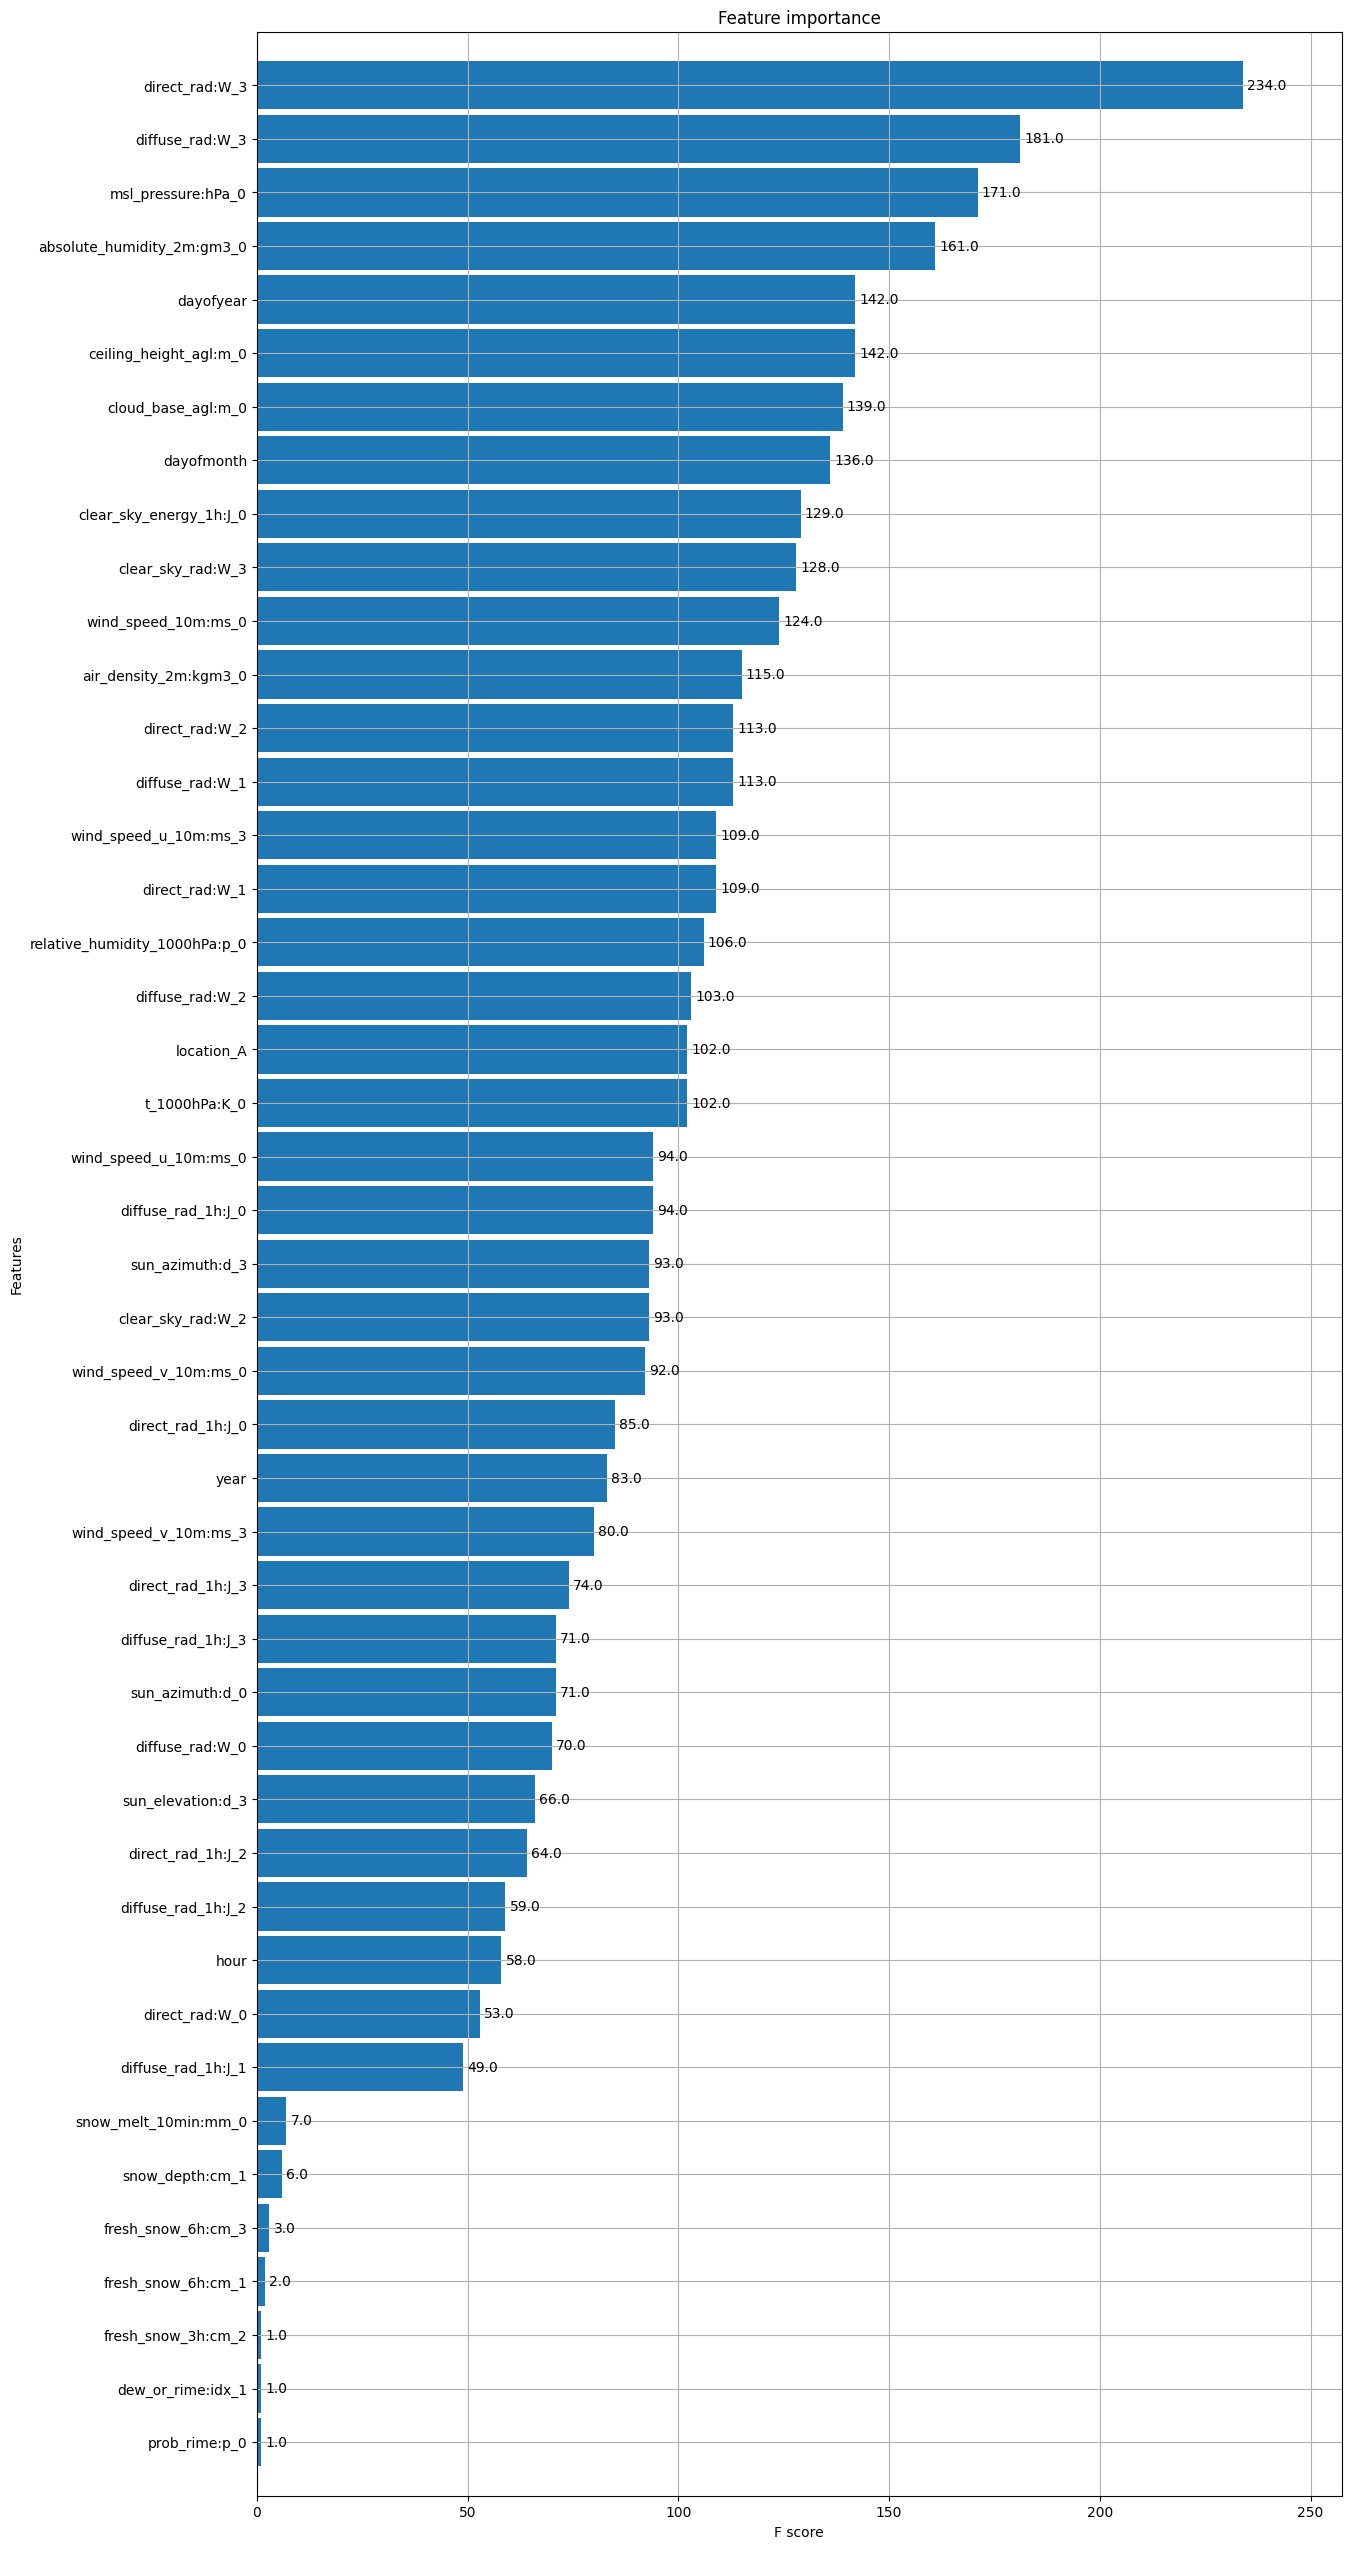

In [859]:
plot_importance(reg_3, height=.9)
plt.gcf().set_size_inches(14, 8 * 4)

# Export sur Kaggle

In [837]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [838]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [839]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler, fit=False)
  return X_test

In [840]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [841]:
X_pred_to_concat = { 'A': X_test_a_test, 'B': X_test_b_test, 'C': X_test_c_test }
X_pred = concat_df_from_differents_locations(X_pred_to_concat)

In [842]:
X_test_a_test['location_A'] = 1
X_test_a_test['location_B'] = 0
X_test_a_test['location_C'] = 0

X_test_b_test['location_A'] = 0
X_test_b_test['location_B'] = 1
X_test_b_test['location_C'] = 0

X_test_c_test['location_A'] = 0
X_test_c_test['location_B'] = 0
X_test_c_test['location_C'] = 1

In [843]:
result_A = y_scaler_a.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg.predict(X_test_a_test)})).reshape(-1)
result_B = y_scaler_b.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg.predict(X_test_b_test)})).reshape(-1)
result_C = y_scaler_c.inverse_transform(pd.DataFrame({'pv_measurement_prediction': reg.predict(X_test_c_test)})).reshape(-1)
results = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [844]:
# results = reg.predict(X_pred)

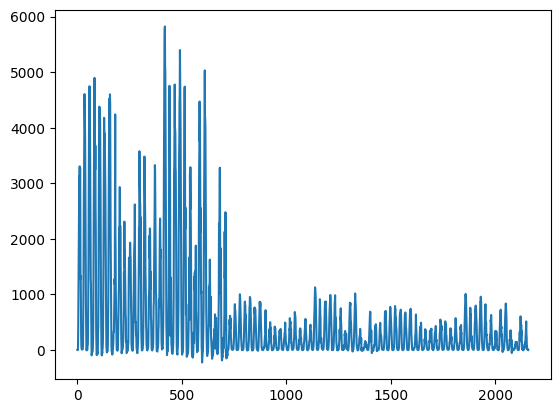

In [845]:
plt.plot(results)

In [846]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = results
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [847]:
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [848]:
negative_values = results[results < 0]
sum_of_negatives = np.sum(negative_values**2)/len(results)
np.sqrt(sum_of_negatives)

16.95804412120297

In [849]:
negative_mask = results < 10
results[negative_mask] = 0

In [850]:
nom_fichier = f'XGBoost_{str(datetime.now().time())}grouped_loc_4_inputs_n_estimators_{n_estimators}_delta_{delta_title}_min_X_scaler_{scaler_name}_y_scaler_{y_scaler_name}_max_depth_{max_depth}_mae_{int(mae)}_{eval_metric}_{int(min_error_a)}_rd_sets_{random_state}_by_day{test_size}'
repertoire = submission_path
test_copy['prediction'] = results
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [851]:
# result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [852]:
# negative_mask2 = result2 < 10
# result2[negative_mask2] = 0